### Clustering Analysis

Questions:
  - Need to figure out what HDBScan is doing to cluster the data. DBScan explained: https://www.youtube.com/watch?v=RDZUdRSDOok. HDBScan explained: https://www.youtube.com/watch?v=dGsxd67IFiU
  - Also see this: https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html
  - Data doesn't seem to cluster well yet. Is the wild-type outcome dominating everything else when it comes to clustering and forcing DBscan to treat everything as noise?
  - Maybe try some simplier single linkage?
  - How will we do log fold change as seen in Hussmann et. al without controls? Could we use the bottom most "active" sgRNAs as ranked through simple Pearson's correlation? Or do we take an average? 
  - How to handle log fold changes when some outcomes drop to zero? Need to consider psuedocounts?
  - We need to identify the cluster of genes which don't affect the repair outcome profiles to act as controls

In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
import sqlite3
from src.config import get_db_file, get_hussmann_supplementary_xlsx
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
con = sqlite3.connect(get_db_file())
df = pd.read_sql_query('select Barcode, Gene, Alias, outcome, fraction_per_barcode from outcomes where Alias is "MB01"', con)
df_idx = df.set_index(["Alias", "Gene", "Barcode", "outcome"])
print("loaded outcomes")
print(df_idx.head(2))

num_genes = df_idx.index.get_level_values("Gene").unique().shape[0]
num_barcodes = df_idx.index.get_level_values("Barcode").unique().shape[0]
num_outcomes = df_idx.index.get_level_values("outcome").unique().shape[0]

print("We have {} unique barcodes covering {} genes, producing {} outcomes".format(num_barcodes, num_genes, num_outcomes))

loaded outcomes
                                                          fraction_per_barcode
Alias Gene          Barcode         outcome                                   
MB01  0610009B22Rik 0610009B22Rik-1 DELETION|-10|0||0bp               0.001243
                                    DELETION|-10|19||1bp              0.000355
We have 86569 unique barcodes covering 18363 genes, producing 514242 outcomes


In [4]:
df_idx_norm_mean = df_idx.groupby(level=["Alias", "Gene", "outcome"]).mean()
totals = df_idx_norm_mean[["fraction_per_barcode"]].sum(level="Gene")
df_idx_norm_mean = df_idx_norm_mean[["fraction_per_barcode"]].div(totals, level="Gene").droplevel(level="Alias")
print("Normalised per Gene")
# print(df_idx_norm_mean.head(2))

BASELINE_FREQUENCY = 0.002
frequent_outcomes = (df_idx_norm_mean.groupby("outcome").sum().div(num_genes)) > BASELINE_FREQUENCY
frequent_outcomes = frequent_outcomes[frequent_outcomes["fraction_per_barcode"]]
frequent_outcomes = frequent_outcomes.index
frequent_outcomes


df_idx_norm_mean_reduced = df_idx_norm_mean.loc[df_idx_norm_mean.index.get_level_values("outcome").isin(frequent_outcomes)]
totals = df_idx_norm_mean_reduced[["fraction_per_barcode"]].sum(level="Gene")
df_idx_norm_mean_reduced = df_idx_norm_mean_reduced[["fraction_per_barcode"]].div(totals, level="Gene")
print("Normalised frequent outcomes")
# print(df_idx_norm_mean_reduced.head(2))

df_outcome_profiles = df_idx_norm_mean_reduced.reset_index().pivot(index=["Gene"], columns="outcome", values="fraction_per_barcode").fillna(0)
df_outcome_profiles.index = df_outcome_profiles.index.str.lower()
print(df_outcome_profiles.iloc[:2, :3])
print("Repair outcome profiles created")

/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_73227/2412254448.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  totals = df_idx_norm_mean[["fraction_per_barcode"]].sum(level="Gene")


Normalised per Gene


/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_73227/2412254448.py:15: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  totals = df_idx_norm_mean_reduced[["fraction_per_barcode"]].sum(level="Gene")


Normalised frequent outcomes
outcome        DELETION|-10|2||1bp  DELETION|-10|5||3bp  DELETION|-10|6||2bp
Gene                                                                        
0610009b22rik             0.003722             0.006112             0.002530
0610010k14rik             0.004118             0.004862             0.004695
Repair outcome profiles created


Below we run hierarchical clustering and complete linkage on the data use correlation as the metric. This takes about 6 minutes to run end to end. Need to figure out how to plot it correctly. We can scale the data to better help with visualising the matrix, but it will have no impact when using Pearson's correlation for clustering as Pearson's correlation is not affected by scale

In [65]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# indexes = df_outcome_profiles.index
# columns = df_outcome_profiles.columns
# df_outcome_profiles = scaler.fit_transform(df_outcome_profiles)
# df_outcome_profiles = pd.DataFrame(df_outcome_profiles, index=indexes, columns=columns)
# df_outcome_profiles.head()

In [122]:
from scipy.cluster import hierarchy as hc

z = hc.linkage(df_outcome_profiles, method="complete", metric="correlation")

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


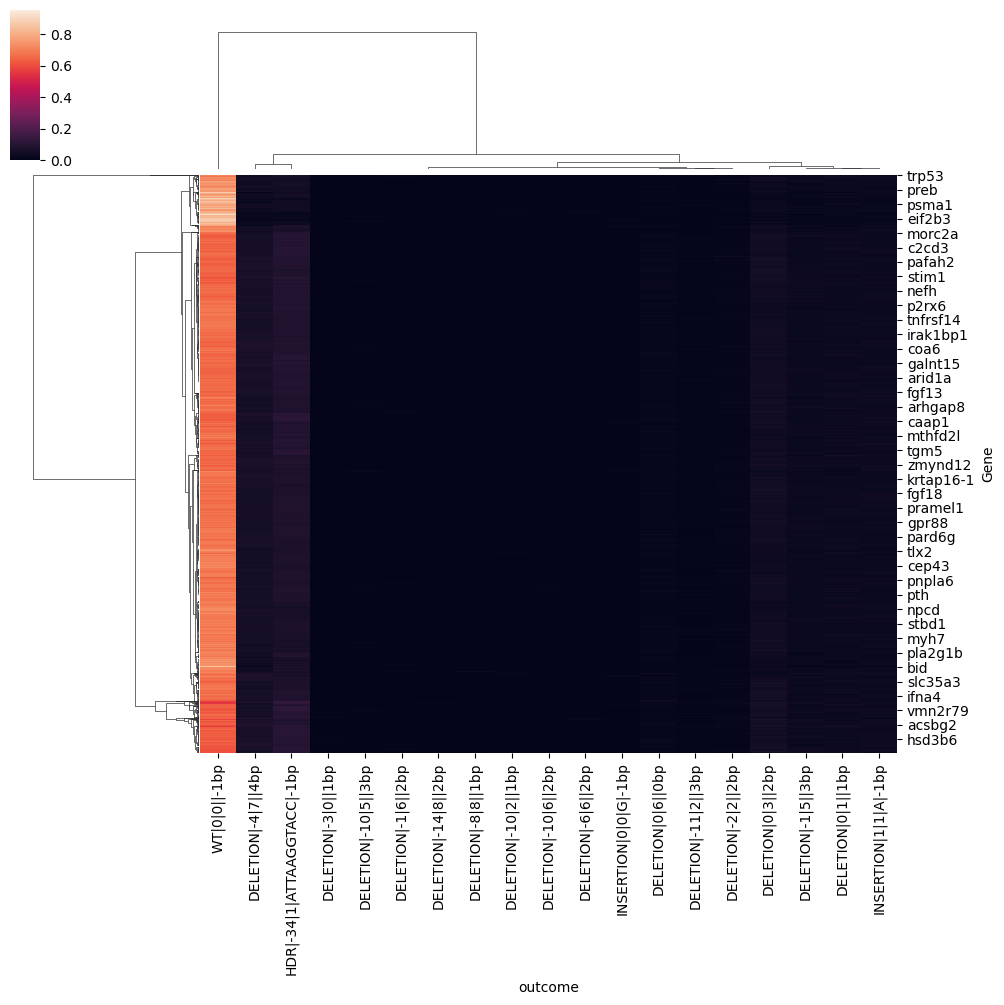

In [123]:
import sys
sns.clustermap(df_outcome_profiles, method="complete", row_linkage=z, cbar_pos=(0, 0.85, .03, .15))

At this point, we can check the membership of the "most correlated genes". See `24082022_ranked_genes.ipynb` for reference.

In [5]:
df_outcome_profiles_corr = df_outcome_profiles.T.corr()
df_outcome_profiles_corr.head()

Gene,0610009b22rik,0610010k14rik,0610030e20rik,0610040j01rik,1110004f10rik,1110017d15rik,1110032a03rik,1110032f04rik,1110059e24rik,1110059g10rik,...,zxdb,zxdc,zyg11a,zyg11b,zyx,zzef1,zzz3,a,ccdc198,mei-04
Gene,,,,,,,,,,,,,,,,,,,,,
0610009b22rik,1.000000,0.999633,0.998627,0.998339,0.999375,0.999141,0.999036,0.999792,0.998168,0.997868,...,0.999622,0.999570,0.999528,0.999471,0.999651,0.999708,0.999550,0.998430,0.999727,0.999024
0610010k14rik,0.999633,1.000000,0.999353,0.999368,0.998700,0.999776,0.999480,0.999597,0.999124,0.999078,...,0.999804,0.999928,0.999639,0.999182,0.999108,0.999214,0.999237,0.999251,0.999092,0.998874
0610030e20rik,0.998627,0.999353,1.000000,0.999306,0.997466,0.999270,0.998662,0.998858,0.998719,0.998741,...,0.999388,0.999469,0.999024,0.998330,0.997489,0.998319,0.997821,0.999393,0.998108,0.998329
0610040j01rik,0.998339,0.999368,0.999306,1.000000,0.997023,0.999185,0.998445,0.998245,0.999424,0.999425,...,0.999397,0.999506,0.999071,0.997847,0.997406,0.997937,0.997707,0.998869,0.997526,0.998093
1110004f10rik,0.999375,0.998700,0.997466,0.997023,1.000000,0.997996,0.998125,0.999397,0.996484,0.995894,...,0.998709,0.998603,0.999208,0.999641,0.999607,0.999744,0.999177,0.996700,0.999528,0.999032


In [6]:
from scipy.cluster import hierarchy as hc

z_corr = hc.linkage(df_outcome_profiles_corr, method="complete")

In [126]:
sns.clustermap(df_outcome_profiles_corr, method="complete", row_linkage=z_corr, col_linkage=z_corr, cbar_pos=(0, 0.85, .03, .15))

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


In [ ]:
# plot dendrogram and choose cutoff based on threshold and not "desired" number of clusters

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cluster', ylabel='count'>

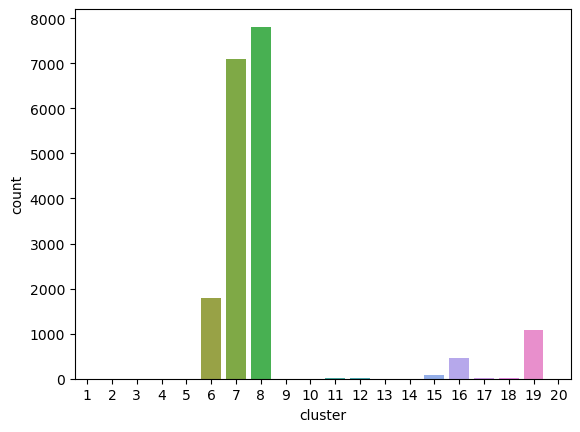

In [101]:
from src.config import get_interim_dir
from scipy import cluster

f = cluster.hierarchy.fcluster(z, t=20, criterion="maxclust")

df_outcome_profile_clusters = pd.DataFrame(f, index=df_outcome_profiles.index, columns=["cluster"])
sns.countplot(df_outcome_profile_clusters.loc[:, "cluster"])

In [102]:
df_outcome_profile_clusters.groupby("cluster").size()

cluster
1        2
2        1
3        1
4        1
5        2
6     1791
7     7101
8     7810
9        1
10       1
11       5
12       5
13       1
14       3
15      89
16     451
17      16
18       6
19    1075
20       1
dtype: int64

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cluster', ylabel='count'>

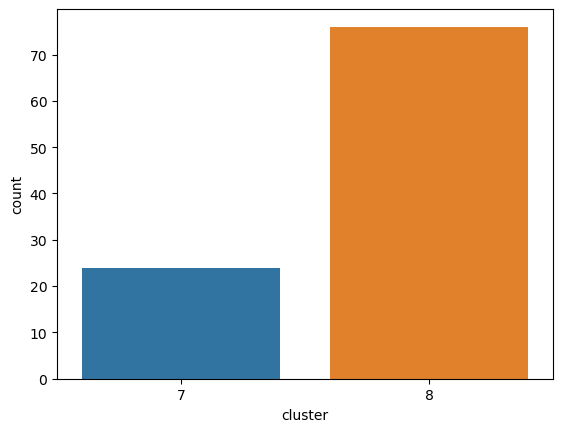

In [91]:
most_correlated_genes = pd.read_csv(get_interim_dir() + "most_correlated_genes.txt")["Gene"]
sns.countplot(df_outcome_profile_clusters.loc[most_correlated_genes, "cluster"])

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cluster', ylabel='count'>

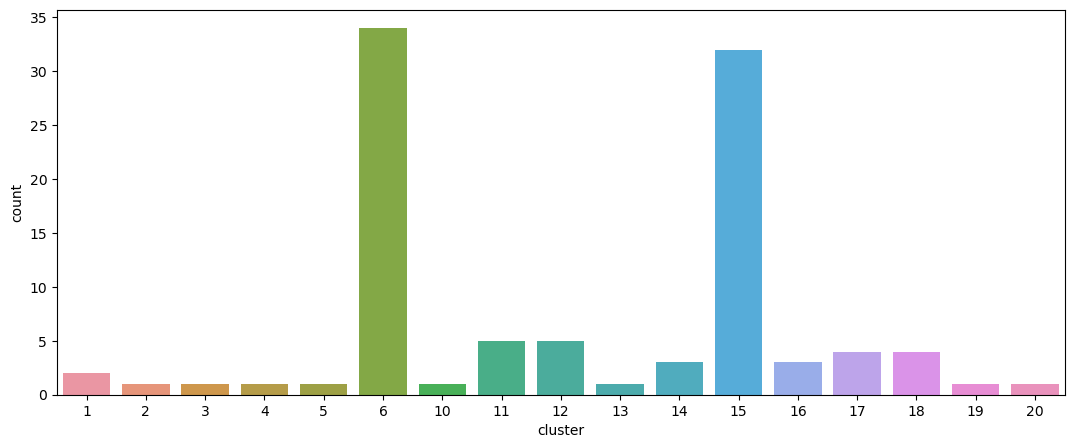

In [92]:
plt.figure(figsize=(13,5))
least_correlated_genes = pd.read_csv(get_interim_dir() + "least_correlated_genes.txt")["Gene"]
sns.countplot(df_outcome_profile_clusters.loc[least_correlated_genes, "cluster"])

From this, we can see that the 100 most and least correlated genes across the entire dataset do not cluster together. The 100 least correlated genes form smaller, seperate clusters. Note that clusters 9 and 35 standout as being quite large, yet seperate from the pack

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cluster', ylabel='count'>

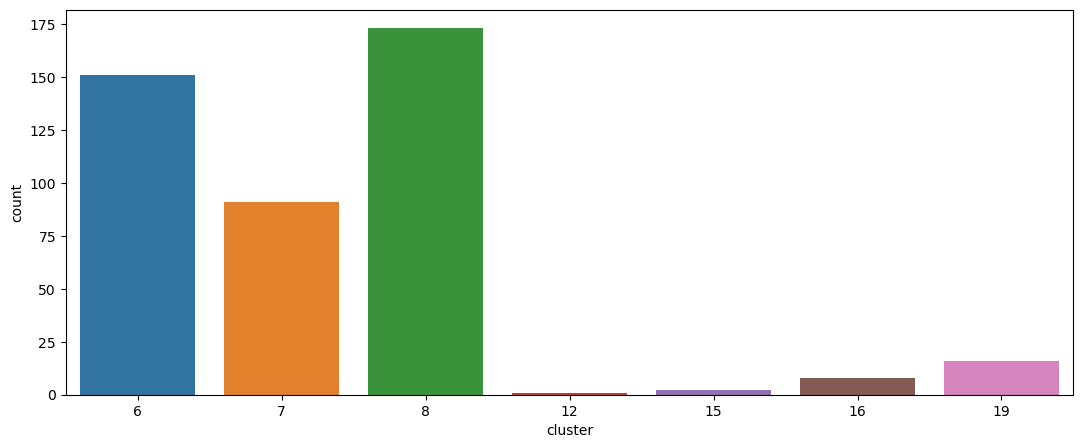

In [112]:
plt.figure(figsize=(13,5))
hussmann_repair_genes = pd.read_excel(get_hussmann_supplementary_xlsx(4), sheet_name="Table S4", skiprows=1)["Gene"].str.lower()
sns.countplot(df_outcome_profile_clusters.loc[df_outcome_profile_clusters.index.isin(hussmann_repair_genes), "cluster"])

We can see that out of the Hussmann Repair Genes, a lot of them cluster with our most "generic" genes in clusters. We would like to know if those genes are "active" according to the Hussmann dataset, so lets check the Hussmann data for the most active genes

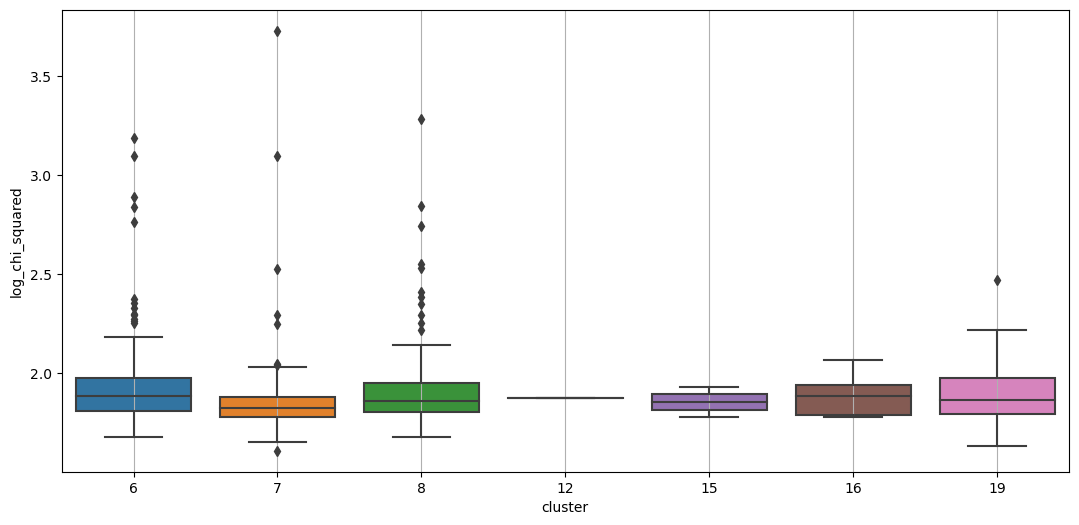

In [110]:
fig, ax = plt.subplots(figsize=(13,6))
hussmann_guide_activity = pd.read_csv(get_interim_dir() + "hussman_guides_chi_squared.txt")
hussmann_guide_activity["gene"] = hussmann_guide_activity["variable_guide"].apply(lambda x: x.split("_")[0].lower())
hussmann_guide_activity["cluster"] = hussmann_guide_activity["gene"].apply(lambda x: df_outcome_profile_clusters.loc[x]["cluster"] if x in df_outcome_profile_clusters.index else -1)
hussmann_guide_activity = hussmann_guide_activity[hussmann_guide_activity["cluster"] != -1]
hussmann_guide_activity["log_chi_squared"] = np.log10(hussmann_guide_activity["chi_squared"])

g = sns.boxplot(data=hussmann_guide_activity.groupby(["cluster", "gene"]).mean().reset_index().sort_values(by="chi_squared", ascending=False), y="log_chi_squared", x="cluster")
# hussmann_repair_gene_activity = hussmann_guide_activity.groupby("gene").max().sort_values(by="chi_squared", ascending=False)
# hussmann_repair_gene_activity["cluster"] = hussmann_repair_gene_activity.index.to_series().apply(lambda x: df_outcome_profile_clusters.loc[x]["cluster"] if x in df_outcome_profile_clusters.index else -1)
# hussmann_repair_gene_activity[hussmann_repair_gene_activity["cluster"] != -1]

ax.yaxis.grid(False) # Hide the horizontal gridlines
ax.xaxis.grid(True) # Show the vertical gridlines

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cluster', ylabel='count'>

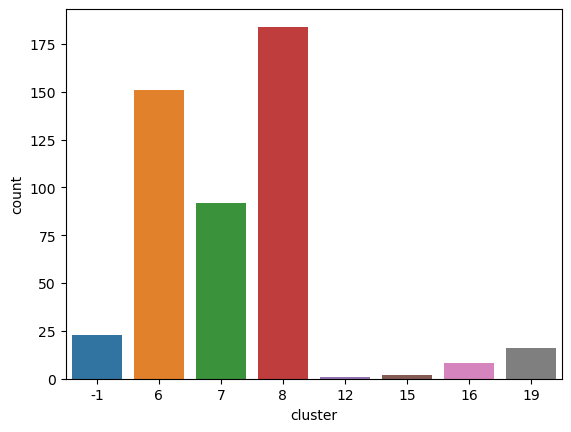

In [107]:
sns.countplot(hussmann_guide_activity.groupby(["cluster", "gene"]).mean().reset_index().sort_values(by="chi_squared", ascending=False)["cluster"])

It seems like, for the Hussmann data, the most active sgRNAs cluster in groups 7, 9, 14, 15, 20. Our least correlated genes cluster in group 9 and 35, while our most correlated (and assumed to be the most inactive) group in clusters 14, 15, 20. 

It could be that these clusters are still too big, and further subdivision could seperate our "most similar genes" into a seperate cluster to the most inactive. Maybe some of the Hussman sgRNAs have small changes in magnitude, but compared to the controls these make the big differences and thus are more "active". 

At this point, it seems like our clustering method may not be informative. However, this may be because we are including the wild-type column, which varies quite dramatically and may be an artifact of the experimental process in most cases. Let's see what the clustering looks like when we exclude this outcome. 

In [114]:
df_outcome_profiles_no_wt = df_outcome_profiles.drop('WT|0|0||-1bp', axis=1)
df_outcome_profiles_no_wt = df_outcome_profiles_no_wt.div(df_outcome_profiles_no_wt.sum(axis=1), axis=0)
z2 = hc.linkage(df_outcome_profiles_no_wt, method="complete", metric="correlation")

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


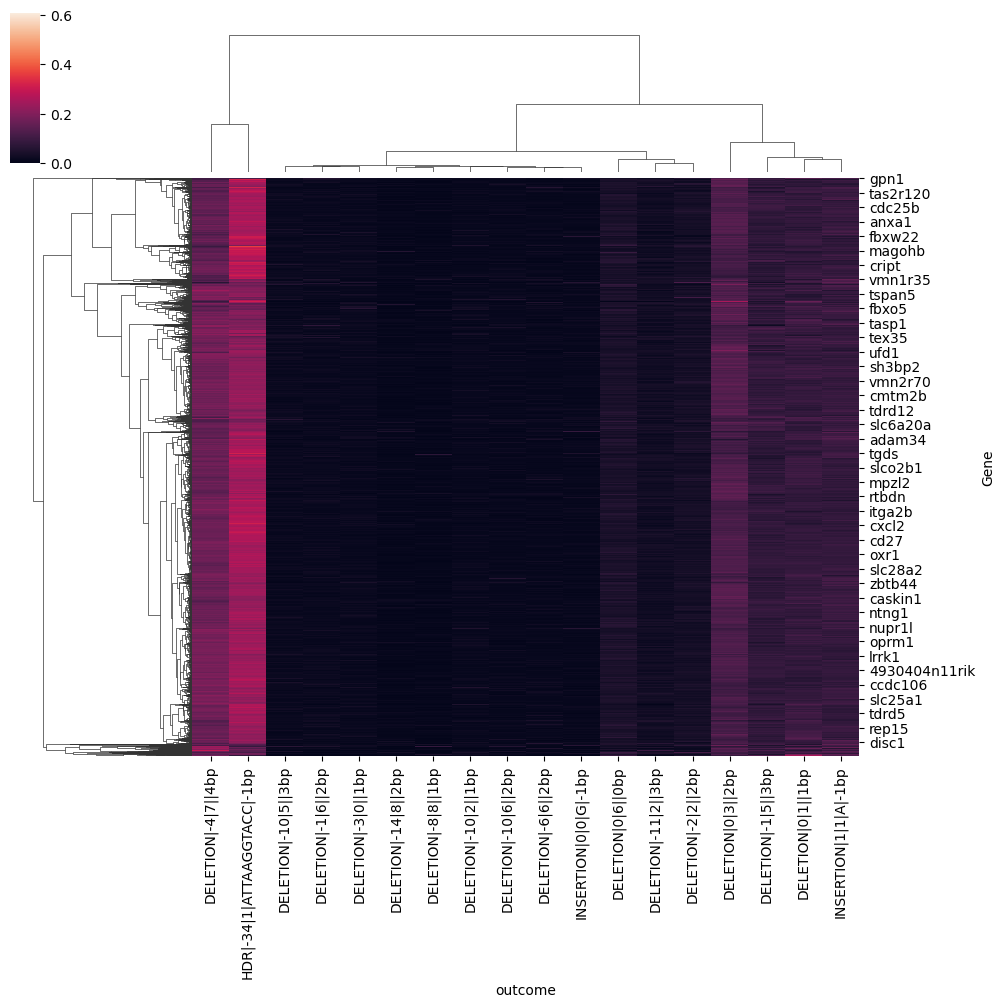

In [115]:
sns.clustermap(df_outcome_profiles_no_wt, method="complete", row_linkage=z2, cbar_pos=(0, 0.85, .03, .15))

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cluster', ylabel='count'>

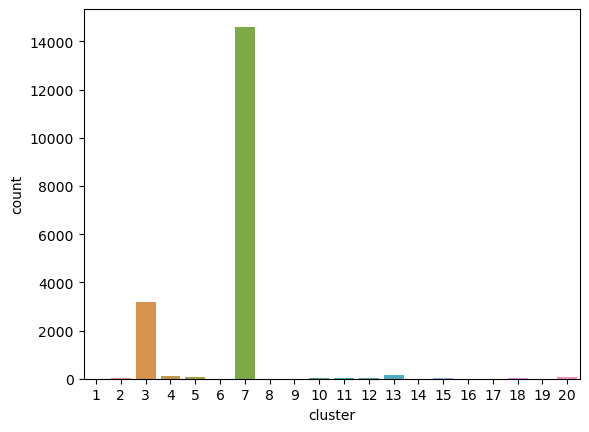

In [116]:
from src.config import get_interim_dir
from scipy import cluster

f2 = cluster.hierarchy.fcluster(z2, t=20, criterion="maxclust")

df_outcome_profile_clusters = pd.DataFrame(f2, index=df_outcome_profiles.index, columns=["cluster"])
sns.countplot(df_outcome_profile_clusters.loc[:, "cluster"])

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cluster', ylabel='count'>

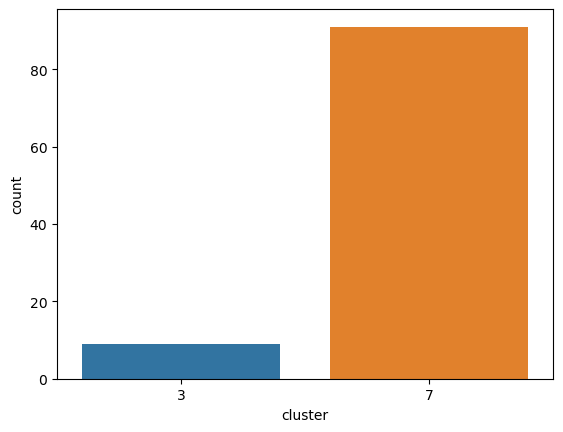

In [117]:
most_correlated_genes = pd.read_csv(get_interim_dir() + "most_correlated_genes.txt")["Gene"]
sns.countplot(df_outcome_profile_clusters.loc[most_correlated_genes, "cluster"])

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cluster', ylabel='count'>

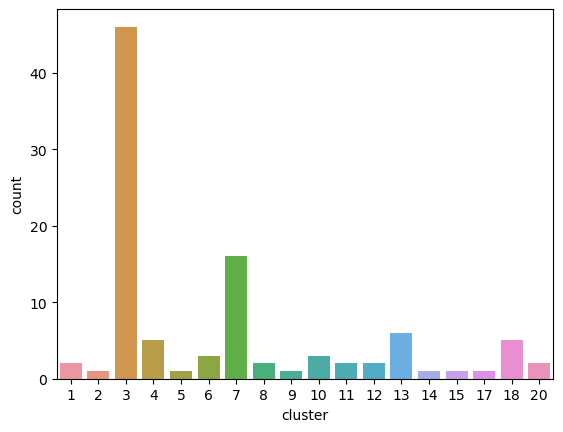

In [118]:
least_correlated_genes = pd.read_csv(get_interim_dir() + "least_correlated_genes.txt")["Gene"]
sns.countplot(df_outcome_profile_clusters.loc[least_correlated_genes, "cluster"])

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cluster', ylabel='count'>

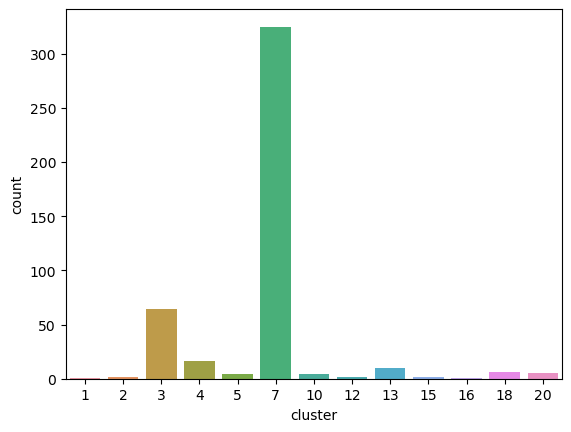

In [119]:
hussmann_repair_genes = pd.read_excel(get_hussmann_supplementary_xlsx(4), sheet_name="Table S4", skiprows=1)["Gene"].str.lower()
sns.countplot(df_outcome_profile_clusters.loc[df_outcome_profile_clusters.index.isin(hussmann_repair_genes), "cluster"])

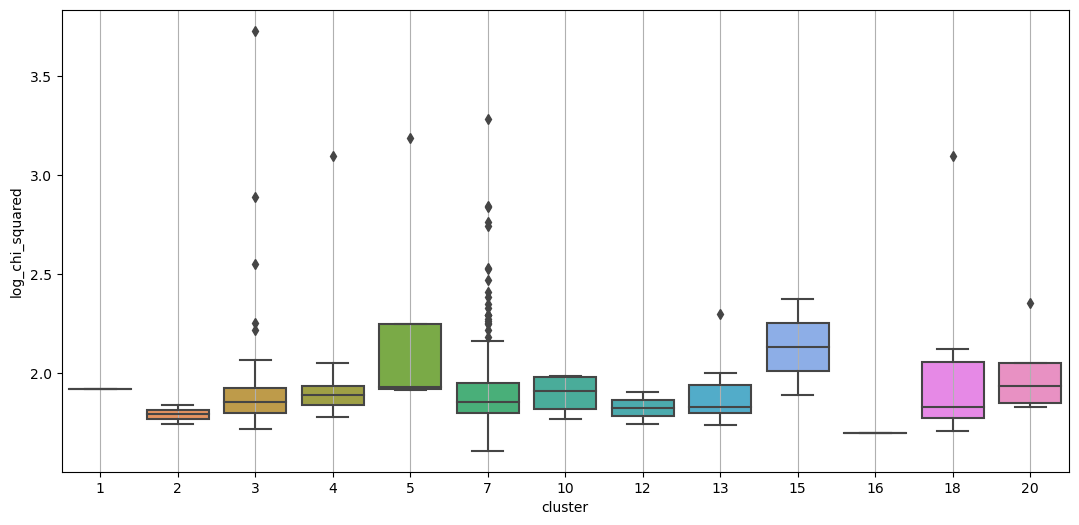

In [120]:
fig, ax = plt.subplots(figsize=(13,6))
hussmann_guide_activity = pd.read_csv(get_interim_dir() + "hussman_guides_chi_squared.txt")
hussmann_guide_activity["gene"] = hussmann_guide_activity["variable_guide"].apply(lambda x: x.split("_")[0].lower())
hussmann_guide_activity["cluster"] = hussmann_guide_activity["gene"].apply(lambda x: df_outcome_profile_clusters.loc[x]["cluster"] if x in df_outcome_profile_clusters.index else -1)
hussmann_guide_activity = hussmann_guide_activity[hussmann_guide_activity["cluster"] != -1]
hussmann_guide_activity["log_chi_squared"] = np.log10(hussmann_guide_activity["chi_squared"])

g = sns.boxplot(data=hussmann_guide_activity.groupby(["cluster", "gene"]).mean().reset_index().sort_values(by="chi_squared", ascending=False), y="log_chi_squared", x="cluster")
# hussmann_repair_gene_activity = hussmann_guide_activity.groupby("gene").max().sort_values(by="chi_squared", ascending=False)
# hussmann_repair_gene_activity["cluster"] = hussmann_repair_gene_activity.index.to_series().apply(lambda x: df_outcome_profile_clusters.loc[x]["cluster"] if x in df_outcome_profile_clusters.index else -1)
# hussmann_repair_gene_activity[hussmann_repair_gene_activity["cluster"] != -1]

ax.yaxis.grid(False) # Hide the horizontal gridlines
ax.xaxis.grid(True) # Show the vertical gridlines

The same problem exists as before. The most "active" genes exist in the same cluster (21) as most of the 100 most correlated genes do. It's hard to guage, through this clustering approach, if those genes are truely not having an impact on the repair outcome profiles

## HDBScan

To investigate at a later time

In [81]:
import hdbscan
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import pairwise_distances

# precompute the cosine distances or euclidian distance
# distance_matrix = pairwise_distances(heatmap_plot_df)
# print(distance_matrix.shape)
# print(distance_matrix[:5,:5])

clusterer = hdbscan.HDBSCAN(metric="correlation")
clusterer.fit(df_outcome_profiles)

HDBSCAN(metric='correlation')

In [82]:
np.unique(clusterer.labels_)

array([-1,  0,  1,  2,  3])

In [83]:
clusterer.probabilities_

array([0., 1., 0., ..., 0., 0., 0.])

In [84]:
cluster1 = df_outcome_profiles.index[clusterer.labels_ == 0]
print("# Members of cluster 1", cluster1.shape)
cluster2 = df_outcome_profiles.index[clusterer.labels_ == 1]
print("# Members of cluster 2", cluster2.shape)
cluster3 = df_outcome_profiles.index[clusterer.labels_ == 2]
print("# Members of cluster 3", cluster3.shape)
cluster4 = df_outcome_profiles.index[clusterer.labels_ == 3]
print("# Members of cluster 4", cluster4.shape)
unclustered = df_outcome_profiles.index[clusterer.labels_ == -1]
print("Unclustered", unclustered.shape)

# Members of cluster 1 (43,)
# Members of cluster 2 (9,)
# Members of cluster 3 (2698,)
# Members of cluster 4 (16,)
Unclustered (15597,)


### Log Fold Change Relative to Average Profile/Non-repair outcome related gene profiles

In [85]:
df_outcome_profile_mean = df_outcome_profiles.mean()
df_outcome_profile_mean = df_outcome_profile_mean/df_outcome_profile_mean.sum()

# X is original value
# Y is final value
# fold change is (Y - X)/X or Y/X - 1

X = df_outcome_profile_mean
Y = df_outcome_profiles

df_outcome_profiles_log2fc = np.log2(Y/X)
df_outcome_profiles_log2fc.head(2)

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


outcome,DELETION|-10|2||1bp,DELETION|-10|5||3bp,DELETION|-10|6||2bp,DELETION|-11|2||3bp,DELETION|-14|8||2bp,DELETION|-1|5||3bp,DELETION|-1|6||2bp,DELETION|-2|2||2bp,DELETION|-3|0||1bp,DELETION|-4|7||4bp,DELETION|-6|6||2bp,DELETION|-8|8||1bp,DELETION|0|1||1bp,DELETION|0|3||2bp,DELETION|0|6||0bp,HDR|-34|1|ATTAAGGTACC|-1bp,INSERTION|0|0|G|-1bp,INSERTION|1|1|A|-1bp,WT|0|0||-1bp
Gene,,,,,,,,,,,,,,,,,,,
0610009b22rik,-0.241856,0.213201,-0.655408,0.218520,-0.529982,0.375385,0.456809,-0.439386,-0.980871,0.060364,-0.235867,-0.960425,0.168878,0.085844,-0.141871,0.212680,-0.296327,0.145971,-0.049323
0610010k14rik,-0.095927,-0.116877,0.236380,-0.017975,0.517093,0.108480,-0.072347,-0.191737,0.244219,0.002565,0.230615,0.053543,-0.065562,0.070990,-0.094969,0.029255,-0.040118,-0.141740,-0.004384


In [86]:
df_outcome_profiles.loc["cdk1"]

outcome
DELETION|-10|2||1bp           0.000000
DELETION|-10|5||3bp           0.012198
DELETION|-10|6||2bp           0.006887
DELETION|-11|2||3bp           0.009756
DELETION|-14|8||2bp           0.000000
DELETION|-1|5||3bp            0.014367
DELETION|-1|6||2bp            0.003052
DELETION|-2|2||2bp            0.004975
DELETION|-3|0||1bp            0.000000
DELETION|-4|7||4bp            0.027759
DELETION|-6|6||2bp            0.001743
DELETION|-8|8||1bp            0.000000
DELETION|0|1||1bp             0.013726
DELETION|0|3||2bp             0.015087
DELETION|0|6||0bp             0.007068
HDR|-34|1|ATTAAGGTACC|-1bp    0.012187
INSERTION|0|0|G|-1bp          0.005165
INSERTION|1|1|A|-1bp          0.006288
WT|0|0||-1bp                  0.859741
Name: cdk1, dtype: float64